# Fine Tuning of Feature encoder

A very common way of applying deep learning techniques in digital pathology is Multiple Instance Learning (MIL) 
The giga pixel image is cropped into a set of equally sized non overlapping tiles. The tiles are encoded with a pretrained feature extractor and then aggregated within in a second step by a trainable model to solve a specific task. 
Tipically used feature encoders were pretrained either on Imagenet21k or even on larger histological datasets. The architectures of such models can reach from smaller ones like the Resnet18  up to Swim transformer based transformer architectures. 
Since pre training larger models from scratch requires huge amounts of ressources, the focus of this model is fine tuning a pretrained model. 

**The following experiments attempt to explore whether existing feature encoders can be fine-tuned for better survival analysis.**


The aim is to carry out the following experiments:

1. Resnet18: train from scratch/fine tune on Survival Analysis
2. ViT Tiny: train from scratch/fine tune on Survival Analysis (+Multimodality)
3. Vit Tiny MAE: fine tune on Survival Analysis 
4. Vit Tiny MAE: fine tune on Survival Analysis in a supMAE fashion

To aquire those experiments, the following subtasks are needed: 
1. Create a custom dataset(from zip) that statifies on a patient level into a train/test split.
2. Create models,find checkpoints,load parameters such that DDP is applicable
3. Create a training function which allows partially freezing weights, finetune, train from checkpoint.
4. Create an encoding pipeline. 


# DataLoader

The Data consists of ~1000 patients. Each patient has exactly one genetic feature vector and can have multiple sets(can have multiple slides) of tile-sets.

Idea: 

The dataloader receives a dataframe which contains meta data and genetic data (stratified by train/test split on a patient level)
and further a path to the tiles. From this path, an os.walk is done to create a second dataframe which contains the file path and the slide_id.
the dataframe will be adapted to contain the tile_path, meta data and the index of the respecitve row within the genomic tensor

1. Import Dataframe, create Gen tensor, metadataframe
2. os.walk on tilepath to create tile dataframe,
3.  add mapping for slide_id idx


In [ ]:
# 1.)
from utils.Aggregation_Utils import *
df_path = ...
df_train,df_test,df_val = prepare_csv(df_path="/work4/seibel/PORPOISE/datasets_csv/tcga_brca_all_clean.csv.zip",split="traintestval",n_bins=4,save = False,frac_train=0.7,frac_val=0.1)
df_train = df_train[df_train["traintest"]==0] # if train 



genomics_tensor = torch.Tensor(df_train[df_train.keys()[11:]].to_numpy()).to(torch.float32)
df_meta = df_train[["slide_id","survival_months_discretized","censorship","survival_months"]]
diction = dict([(name,idx) for idx,name in enumerate(df_meta["slide_id"]) ])

In [ ]:
#2.)
import os
import pandas as pd
tile_path = "/globalwork/seibel/TCGA-BRCA-TILES-NORM/"
ext = "jpg"
file_list = []
root_list = []
for root, dirs, files in os.walk(tile_path, topdown=False):
    for name in files:
        file_list.append(os.path.join(root, name))
        root_list.append(root.split("/")[-1]+".svs")

df_tiles = pd.DataFrame({"tilepath":file_list,"slide_id":root_list},)
df_tiles = df_tiles[df_tiles["tilepath"].str.endswith(ext)] # Avoid having other files than .<ext> files in Dataframe


print(df_tiles.tilepath.iloc[0])
print(df_tiles.slide_id.iloc[0])
df_tiles.head()

## safe dataframe

In [ ]:
#title = "df-TCGA-BRCA-TIILES-NORM.csv"
#df_tiles.to_csv(title,index=False)

In [ ]:
# 3.)
df_tiles.insert(2,"slideid_idx",df_tiles["slide_id"].map(diction))
df_tiles = df_tiles.dropna()
df_tiles.slideid_idx = df_tiles.slideid_idx.astype(int)
df_tiles

## Complete Custom Dataset
It is better to create the dataframe once instead of including the os-walk within the dataloader! 

In [ ]:
from torch.utils.data import DataLoader,Dataset
from utils.Aggregation_Utils import *
import pandas as pd
import os 
from PIL import Image
from torchvision import transforms



class TileDataset(Dataset):
    def __init__(self,df_path,tile_path,ext,trainmode,transform):
        """Custom Dataset for Feature Extractor Finetuning for Survival Analysis 

        Args:
            df_path (str): Path to Dataframe which contains meta data and genomic data 
            tilepath (str): path to folder which contains subfolders with tiles(subfolder names must ne slide id)
            ext (str): file extension of tiles(eg jpg or png)
            trainmode (Bool): To generate train set or test set 
        """
        super(TileDataset,self).__init__()
        #Genomic Tensor and Meta Dataframe
        df = pd.read_csv(df_path) 

        assert trainmode in ["train","test","val"], "Dataset mode not known"
        df[df["traintest"]==(0 if trainmode=="train" else 1 if trainmode=="test" else 2)]
        
            
        self.genomics_tensor = torch.Tensor(df[df.keys()[11:]].to_numpy()).to(torch.float32)
        self.df_meta = df[["slide_id","survival_months_discretized","censorship","survival_months"]]
        
        # Tile Data Frame
        file_list = []
        root_list = []
        for root, dirs, files in os.walk(tile_path, topdown=False):
            for name in files:
                file_list.append(os.path.join(root, name))
                root_list.append(root.split("/")[-1]+".svs")


        df_tiles = pd.DataFrame({"tilepath":file_list,"slide_id":root_list},)
        df_tiles = df_tiles[df_tiles["tilepath"].str.endswith(ext)]
        
        # add slide_id to index mapping
        diction= dict([(name,idx) for idx,name in enumerate(self.df_meta["slide_id"]) ]) 
        df_tiles.insert(2,"slideid_idx",df_tiles["slide_id"].map(diction))
        df_tiles = df_tiles.dropna()
        df_tiles.slideid_idx = df_tiles.slideid_idx.astype(int)
        self.df_tiles = df_tiles
        
        # TODO transforms 
        self.transforms = transform
    def __len__(self):
        return len(self.df_tiles)
    def __getitem__(self,idx):
        
        tile_path,_,slide_idx = self.df_tiles.iloc[idx]
        tile = Image.open(tile_path)
        tile = self.transforms(tile)
        
        label = torch.tensor(self.df_meta.iloc[slide_idx, 1]).type(torch.int64)
        censorship = torch.tensor(self.df_meta.iloc[slide_idx, 2]).type(torch.int64)
        label_cont = torch.tensor(self.df_meta.iloc[slide_idx,3]).type(torch.int64)
        return tile, self.genomics_tensor[slide_idx], censorship, label,label_cont
        
        
        
        
df_path_train = "/work4/seibel/PORPOISE/datasets_csv/tcga_brca__4bins_trainsplit.csv"
df_path_test = "/work4/seibel/PORPOISE/datasets_csv/tcga_brca__4bins_testsplit.csv"

tilepath = "/work4/seibel/data/TCGA-BRCA-TILES/"
ext = "jpg"

trainmode="train"


DS = TileDataset(df_path_train,tilepath,ext,trainmode,transform=transforms.ToTensor())
DS.__getitem__(8)

In [ ]:
from datasets.Tile_Dataset import TileDataset
from torchvision import transforms
import os 
df_path_train ="/nodes/bevog/work4/seibel/PORPOISE/datasets_csv/tcga_brca__4bins_trainsplit.csv"
assert os.path.exists(df_path_train)
tile_path ="/nodes/bevog/work4/seibel/data/TCGA-BRCA-TILES/"
ext = "jpg"
batch_size = 32
transform_train=transforms.PILToTensor()
train_set = TileDataset(df_path=df_path_train,tile_path=tile_path,ext=ext,trainmode = "train",transform=transform_train)

# Loss 
The loss can be used from the previous colab notebook but has to be adapted to fully run on gpu 


In [ ]:
from utils.Aggregation_Utils import Survival_Loss
import torch
B = 10
nbins  = 4 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#hist_tile,gen, censorship, label,label_cont = DS.__getitem__(8)

criterion = Survival_Loss(0.2)
prediction_logits = torch.rand(B,nbins,device=device)
c  = torch.randint(0,2,size=(B,1),device=device)
l = torch.randint(0,nbins,size=(B,),device=device)




criterion(prediction_logits,c,l)

# Survival 


In [ ]:
import torch
from torch import nn
channels = 12
model = nn.Sequential(nn.Conv2d(3, channels, kernel_size=(3, 3), padding='same', bias=True),
                          nn.AdaptiveAvgPool2d(1),
                          nn.Flatten(1),
                          nn.Linear(channels,1),
                          nn.Flatten(0))



x = torch.rand((5,3,16,16))
model(x).size()

In [ ]:
import argparse
import yaml
import os
f = "./encoder_configs/base.yaml"
os.path.exists(f)
with open(f, 'r') as file:
        config = yaml.safe_load(file)
        
print(config["train_settings"]["checkpoint_path"])


In [ ]:
DF1 = ['case_id', 'slide_id', 'site', 'traintest', 'metas','gendata']
DF2 = ['TILEPATH','SLIDE_ID']
#get one tensor for gendata, one df with tilepath, metadata, tensoridx

In [ ]:
mode = "vali"
assert mode in ["train","test","val"], "Dataset mode not known"
df_train.survival_months_discretized[df_train.survival_months_discretized==( 0 if mode=="train" else 1 if mode=="test" else 2)]

In [ ]:
test_len = 2
train_len = 3
diction = dict([(name,0) if idx<train_len else (name,1) if idx<train_len+test_len  else (name,2) for idx,name in enumerate(["a","b","c","d","e","f"])])
diction

In [ ]:
import torch 
from torch import nn
bins = 4
B=12
out_all =[]
c_all =  []
l_all = []

for i in range(9):
    out = torch.rand((B,bins))
    l = torch.randint(0,bins,size=(B,))
    c = torch.randint(0,2,size=(B,))
    
    out_all.append(out)
    l_all.append(l)
    c_all.append(c)


In [ ]:
torch.cat(out_all,dim=0).size()

In [ ]:
from sksurv.metrics import concordance_index_censored
h = nn.Sigmoid()(torch.cat(out_all,dim=0))
S = torch.cumprod(1-h,dim = -1)
risk = -S.sum(dim=1) 
notc = (1-torch.cat(c_all,dim=0)).numpy().astype(bool)
c_index = concordance_index_censored(notc, torch.cat(l_all,dim=0),risk)

# Models




In [ ]:
import torch 
from torch import nn 

class MAE(nn.Module):
    def __init__(self,multimodal,supervised_surv):
        super(MAE,self).__init__()
        self.encoder = nn.Identity()
        self.decoder = nn.Identity()
        self.enc_emb = ...
        self.dec_emb = ...
        self.enc_pos_emb = ...
        self.dec_pos_emb = ...
        self.y_encoder = ...    
        self.masktoken = ...
    def forward(self,x,y):
        x_seq =  img2seq(x)
        unmasked,masked,unmasked_idx,masked_idx = self.masking(x)
        encoded = self.encoder(torch.concat([self.enc_emb(unmasked)+self.enc_pos_emb(unmasked_idx),self.y_encoder(y)],dim=1))
        unmasked_enc,y_enc = torch.split(encoded)# find correct way of splitting
        decoded = torch.cat([self.dec_emb(unmasked_enc)+self.dec_pos_emb(unmasked_idx),self.dec_pos_emb(masked_idx)+ maskedtoken[None:,:]],dim=1)
        _,decoded_masked = torch.split(decoded)#split based on length of mask
        
        if self.supervised_surv:
            surv_in = torch.stack([y_enc,torch.mean(unmasked_enc)])
            
            
        
        return masked, decoded_masked

        
        
        
    def img2seq():
        ...
    def seq2img():
        ...
    def masking():
        ...
        

In [ ]:
#!pip install timm
from models.mae_models.models_mae_modified import mae_vit_tiny_patch16
model = mae_vit_tiny_patch16()

In [ ]:
import torch
B,C,H,W = 20,3,224,224
imgs =  torch.rand((B,C,H,W))
mask_ratio = 0.75
y = torch.rand((B,1,192))
ids_shuffle=None
surv = True

latent, mask, ids_restore, ids_shuffle = model.forward_encoder(imgs, mask_ratio,y, ids_shuffle)
latent_hist,latent_gen = torch.split(latent,split_size_or_sections=[latent.size(1)-1,1],dim=1)
pred = model.forward_decoder(latent_hist, ids_restore)  # [N, L, p*p*3]
lossMAE = model.forward_loss(imgs, pred, mask)

if surv:
    surv_in = torch.cat((torch.mean(latent_hist,dim=1),latent_gen.squeeze(1)),dim=1)
    survivalhead
 

In [ ]:
ckpt_path = "/work4/seibel/data/mae_tiny_400e.pth.tar"
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = {k.replace("module.model.", ""): v for k, v in ckpt["model"].items()}
model.load_state_dict(state_dict, strict=False)


In [ ]:
from PIL import Image
from torchvision import transforms
f = "/globalwork/seibel/TCGA-BRCA-TILES-NORM/TCGA-AN-A0XW-01Z-00-DX1.811E11E7-FA67-46BB-9BC6-1FD0106B789D/TCGA-AN-A0XW-01Z-00-DX1_(9124,21291).jpg"

img = Image.open(f)
img = transforms.ToTensor()(img)

img.size()


In [ ]:
from datasets.Tile_Dataset import TileDataset
from torchvision import transforms
transform_train =  transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.RandomVerticalFlip(p=0.5)
                                                    ]
                                                   )

df_path_train = "/nodes/bevog/work4/seibel/PORPOISE/datasets_csv/tcga_brca__4bins_trainsplit.csv"
tile_df_path = "/nodes/bevog/work4/seibel/multimodal_survival_prediction/datasets/DF_TCGA-BRCA-TIILES-NORM.csv"
trainmode="train"
image_label_dataset = TileDataset(df_path_train,tile_df_path,trainmode,transform=transform_train)

# Benchmark 1 

In [ ]:
from time import time 
import numpy as np 
time1,time2,time3 = [],[],[]
for i in range(1000):
    start1=time()
    for i in range(512):
        _,a,b,c = image_label_dataset.df_meta.iloc[i]
    time1.append(time()-start1)

    start2=time()
    for i in range(512):
        a = image_label_dataset.df_meta.iat[i,1]
        b = image_label_dataset.df_meta.iat[i,2]
        c = image_label_dataset.df_meta.iat[i,3]
    time2.append(time()-start2)

    start3=time()
    for i in range(512):
        a = image_label_dataset.df_meta.iloc[i,1]
        b = image_label_dataset.df_meta.iloc[i,2]
        c = image_label_dataset.df_meta.iloc[i,3]
    time3.append(time()-start3)
    
    
print("time1 :",np.mean(time1),"\ntime2 :",np.mean(time2),"\ntime3",np.mean(time3))
print("time1 :",np.std(time1),"\ntime2 :",np.std(time2),"\ntime3",np.std(time3))

In [ ]:
time1,time2,time3 = [],[],[]
for i in range(1000):
    start1=time()
    for i in range(512):
        a,_,c = image_label_dataset.df_tiles.iloc[i]
    time1.append(time()-start1)

    start2=time()
    for i in range(512):
        a = image_label_dataset.df_tiles.iat[i,0]
        
        c = image_label_dataset.df_tiles.iat[i,2]
    time2.append(time()-start2)

    
    
    
print("time1 :",np.mean(time1),"\ntime2 :",np.mean(time2))
print("time1 :",np.std(time1),"\ntime2 :",np.std(time2))

# Benchmark2

In [ ]:
import torch 
initial_tensor = image_label_dataset.genomics_tensor
f16tensor = initial_tensor.to(torch.float16)
print("avg difference :",torch.mean(torch.abs(initial_tensor-f16tensor)))

print("size :",initial_tensor.flatten().size())
import matplotlib.pyplot as plt 
plt.hist(initial_tensor.flatten().numpy(),bins=1000)
plt.show

In [ ]:
plt.clf()
plt.hist(torch.mean(initial_tensor,dim=1).numpy(),bins=100)
plt.show

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
df_path = "/work4/seibel/PORPOISE/datasets_csv/tcga_brca_all_clean.csv.zip"
df = pd.read_csv(df_path,compression='zip').sample(frac=1,random_state=777)
n_bins = 4
# get time bins 
df_uncensored = (df[df["censorship"]==0]).drop_duplicates(["case_id"])
_,bins = pd.qcut(df_uncensored['survival_months'],q = n_bins,retbins=True)  # distribute censored survival months into quartiles

# adapt time bins 
bins[0] = 0 
bins[-1] = np.inf

# bin name = index 
labels = [i for i in range(n_bins)]
df.insert(6,"survival_months_discretized",  pd.cut(df["survival_months"],
                                                        bins=bins, 
                                                        labels=labels)) # insert binned survival month


In [ ]:
frac_train = 0.7
frac_val = 0.1
cases = list(df["case_id"].unique())
random.shuffle(cases)
cases_len = len(cases)
train_len = int(cases_len*frac_train)
val_len = int(cases_len*frac_val)
test_len = cases_len-train_len-val_len

diction = dict([(name,0) if idx<train_len else (name,1) if idx<train_len+test_len  else (name,2) for idx,name in enumerate(cases)])
df.insert(3,"traintest",df["case_id"].map(diction)) # insert traintestlabel 

genomics = df[df.keys()[11:]]
scaler = StandardScaler()
scaled_genomics = scaler.fit_transform(genomics)
df[df.keys()[11:]] = scaled_genomics

In [ ]:
#print("mean all: ",np.mean(df[df.keys()[11:]].to_numpy(),axis=0))
#np.mean(df[df["traintest"]==2][df.keys()[11:]].to_numpy(),axis=0)

plt.clf()
kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=20)

plt.hist(np.mean(df[df["traintest"]==0][df.keys()[11:]].to_numpy(),axis=0),label="train", **kwargs)
plt.hist(np.mean(df[df["traintest"]==1][df.keys()[11:]].to_numpy(),axis=0),label="test", **kwargs)
plt.hist(np.mean(df[df["traintest"]==2][df.keys()[11:]].to_numpy(),axis=0),label="val", **kwargs)
plt.hist(np.mean(df[df["traintest"]!=2][df.keys()[11:]].to_numpy(),axis=0),label="train+test", **kwargs)
#plt.hist(np.mean(df[df.keys()[11:]].to_numpy(),axis=0),label="full", **kwargs)
plt.legend()

plt.plot


In [ ]:
import torch 
from  torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.ToTensor()

                

df_path = "/nodes/bevog/work4/seibel/PORPOISE/datasets_csv/tcga_brca__4bins_trainsplit.csv"
tile_df_path = "/nodes/bevog/work4/seibel/multimodal_survival_prediction/datasets/DF_TCGA-BRCA-TIILES-NORM.csv"
trainmode="train"
ds = TileDataset(df_path,tile_df_path,trainmode,transform)
dataloader = DataLoader(ds, batch_size=512)

# Check Structure of bag of tiles

The bag of tiles are stored as hdf5 files containing the features and the coordinates
1. "feats" stored as float16
2. "coords" stored as int64

In [ ]:
import h5py
tensor_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/tcga_brca_20x_features/pt_files/TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4BD-C6B76294C291.h5"
tensor_file =h5py.File(tensor_path, "r")
print("Keys :",list(tensor_file.keys()))
print("Coordinates dtype :",tensor_file["coords"][:].dtype,"  |    shape : (N,D)","    |  N = #encoded tiles, D =dimension of encoding")
print("Feature dtype :",tensor_file["feats"][:].dtype,"    |    shape : (N,2)","    | (X,Y) coordinates")

# Store & Load own Files

In [ ]:
import h5py
import numpy as np
import torch 
dvec = torch.rand((32,912)).to(torch.float16).numpy()
coords = torch.rand((32,2)).to(torch.int64).numpy()
with h5py.File("mytestfil2.hdf5", "w") as f:
    coords = f.create_dataset("coords", data=dvec)
    feats = f.create_dataset("feats", data=coords)
    

In [ ]:
tensor_path = "/nodes/bevog/work4/seibel/multimodal_survival_prediction/mytestfil2.hdf5"
with h5py.File(tensor_path, "r") as f:
    dvec = f["coords"][:]
    dcoord = f["feats"][:]

# Encode Features and create new Dataset


In [69]:
from models.Encoder_Models import SupViTSurv
from PIL import Image
import os 
import torch 
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt

f_trainslides = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_trainsplit.csv"
f_foldertiles = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-TILES/TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EEB-A3606BCF0C96"
f_trainset = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_trainsplit.csv"
encode_gen = False
ckpt_path =  "/nodes/bevog/work4/seibel/data/mae_tiny_400e.pth.tar" # for None -> random weights and masking = 1 -> output image should be ranodm noise 
model =  SupViTSurv(lr=0.01,nbins=4,alpha=0.1,ckpt_path=ckpt_path,ffcv=False,encode_gen=encode_gen)


## create 
tilepaths = [os.path.join(f_foldertiles,tilename) for tilename in os.listdir(f_foldertiles) if tilename.endswith("jpg")]
coords = [list(map(int,tiles.split("(")[-1].split(")")[0].split(","))) for tiles in tilepaths]


transform =  transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                ]
                               )

df_genomics = pd.read_csv(f_trainset)


In [5]:
mycheckpnt = "/nodes/bevog/work4/seibel/data/testing/lightning_logs/o8svd1da/checkpoints/epoch=19-step=36180.ckpt"
encode_genm2 = False
model2 =  SupViTSurv(lr=0.01,nbins=4,alpha=0.1,ckpt_path=ckpt_path,ffcv=False,encode_gen=encode_genm2)
model2.load_from_checkpoint(mycheckpnt)

#with genomics
mycheckpnt = "/nodes/bevog/work4/seibel/data/testing/lightning_logs/o8svd1da/checkpoints/epoch=19-step=36180.ckpt"
encode_genm3 = True
model3 =  SupViTSurv(lr=0.01,nbins=4,alpha=0.1,ckpt_path=ckpt_path,ffcv=False,encode_gen=encode_genm3)
model3.load_from_checkpoint(mycheckpnt)

SupViTSurv(
  (model): MaskedAutoencoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (identity): Identity()
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          

In [43]:
def plotter(mod,batch,maks_ratio,encode_gen=False):
    with torch.no_grad():
        if encode_gen:
            latent,conc_latent,coords,ids_restore = mod.predict_step(batch,batch_idx=1,mask_ratio=mask_ratio) #latent encoding
        else:
            latent,coords,ids_restore = mod.predict_step(batch,batch_idx=1,mask_ratio=mask_ratio) #latent encoding
        model.eval()
        pred = mod.model.forward_decoder(latent, ids_restore)
        print("Size :",pred.size())
        output = mod.model.unpatchify(pred)[0]
        featurevec = torch.mean(latent,dim=1)
        featurevec = torch.clamp(featurevec,-0.5,1)

    
    #output = torch.clamp(output,-0.5,1)
    mu = output.min()
    sig = output.max() - mu 
    backtransform =  transforms.Compose([transforms.Normalize(mean=(mu,mu,mu),std=(sig,sig,sig)), 
                                        transforms.ToPILImage()
                                    ]
                                )
    print(f"Min val: {round(output.min().item(),2)} |  Max val: {round(output.max().item(),2)}")
    return Image.open(tilepaths[i]),backtransform(output),featurevec

Pretrained Tiny-ViT on Imagenet1k 
Size : torch.Size([1, 196, 768])
Min val: -6.9 |  Max val: 5.02
Pretrained Tiny-ViT on Imagenet1k, finetuned for 20 epochs on Hist Data+ Gen
Size : torch.Size([1, 196, 768])
Min val: -6.84 |  Max val: 4.93
Size : torch.Size([1, 196, 768])
Min val: -7.31 |  Max val: 4.52


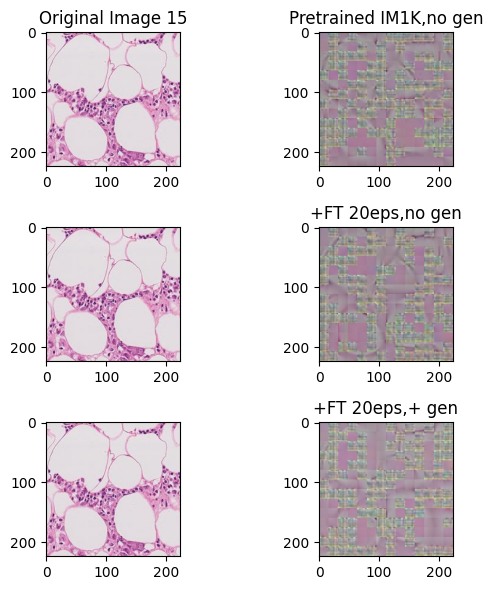

In [44]:
i = 15
mask_ratio=0.5
tile = transform(Image.open(tilepaths[i])).unsqueeze(0) #x 
coordinate = coords[i] # coords

slide_id = f_foldertiles.split("/")[-1]+".svs"
gen_vec = torch.Tensor(df_genomics[df_genomics.slide_id==slide_id][df_genomics.keys()[11:]].to_numpy()).to(torch.float32)
gen_empty = torch.rand(size=(1,0,192)) # y 
 
batch = [tile,gen_empty,coordinate]
batch_w_gen = [tile,gen_vec,coordinate]


print("Pretrained Tiny-ViT on Imagenet1k ")
m1_raw,m1_out,out_mean1 = plotter(mod=model,batch=batch,maks_ratio=mask_ratio)
print("Pretrained Tiny-ViT on Imagenet1k, finetuned for 20 epochs on Hist Data+ Gen")
m2_raw,m2_out,out_mean2 = plotter(mod=model2,batch=batch,maks_ratio=mask_ratio)
m3_raw,m3_out,out_mean3 = plotter(mod=model3,batch=batch_w_gen,maks_ratio=mask_ratio,encode_gen=True)

fig, ax = plt.subplots(3,2,figsize=(6,6))
ax[0,0].imshow(m1_raw)
ax[0,1].imshow(m1_out)
ax[1,0].imshow(m2_raw)
ax[1,1].imshow(m2_out)
ax[2,0].imshow(m3_raw)
ax[2,1].imshow(m3_out)
ax[0,0].set_title(f"Original Image {i}")    
ax[0,1].set_title(f"Pretrained IM1K,no gen")
ax[1,1].set_title(f"+FT 20eps,no gen")
ax[2,1].set_title(f"+FT 20eps,+ gen")
fig.tight_layout()

<function matplotlib.pyplot.show(close=None, block=None)>

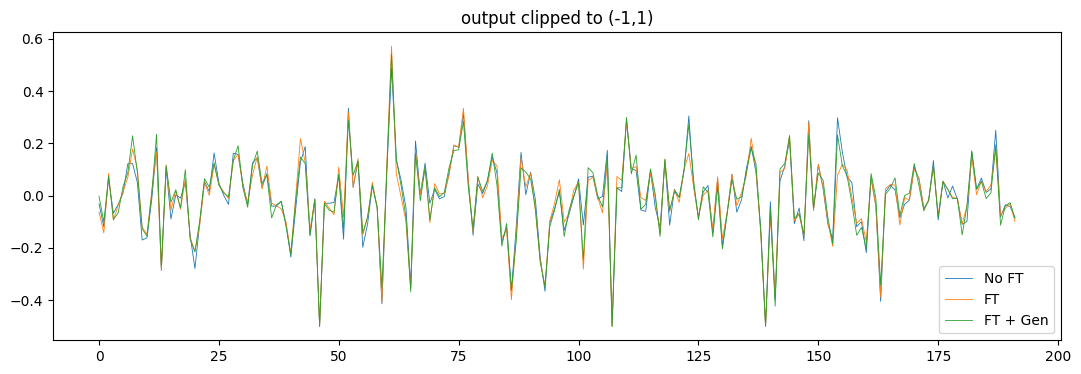

In [45]:
plt.clf
plt.figure(figsize=(13,4))
plt.title("output clipped to (-1,1)")
plt.plot(out_mean1.squeeze().numpy(),linewidth=0.6,label="No FT")
plt.plot(out_mean2.squeeze().numpy(),linewidth=0.6,label="FT")
plt.plot(out_mean3.squeeze().numpy(),linewidth=0.6,label="FT + Gen")
plt.legend(loc="lower right")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

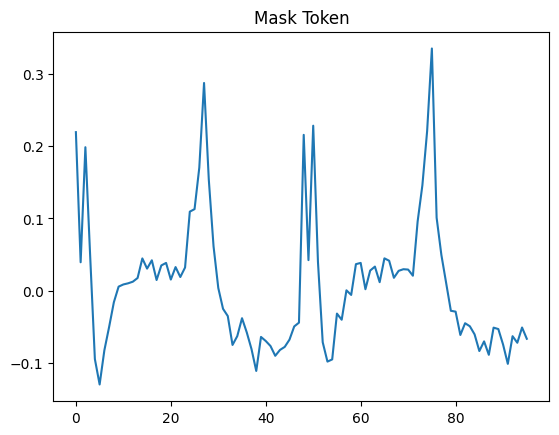

In [170]:
plt.clf()
plt.plot(model.model.mask_token.detach().squeeze().numpy())
plt.title("Mask Token")
plt.show

In [81]:
    
encode_gen = True
mask_ratio=0.5
i = 15
slide_id = f_foldertiles.split("/")[-1]+".svs"

gen_vec = torch.Tensor(df_genomics[df_genomics.slide_id==slide_id][df_genomics.keys()[11:]].to_numpy()).to(torch.float32)
tile_batch = []
gen_vec_batch = []
coordinate_batch = []
for i in range(len(tilepaths)):
    tile = transform(Image.open(tilepaths[i])).unsqueeze(0) #x 
    coordinate = torch.tensor(coords[i]) # coords
    tile_batch.append(tile)
    gen_vec_batch.append(gen_vec)
    coordinate_batch.append(coordinate)

mini_batch = [torch.cat(tile_batch,dim=0),torch.cat(gen_vec_batch,dim=0),torch.cat(coordinate_batch,dim=0)]

with torch.no_grad():
        if encode_gen:
            latent,conc_latent,coords,ids_restore = model3.predict_step(mini_batch,batch_idx=1,mask_ratio=mask_ratio) #latent encoding
            featurevec = conc_latent
        else:
            latent,coords,ids_restore = mod.predict_step(mini_batch,batch_idx=1,mask_ratio=mask_ratio) #latent encoding
            featurevec = torch.mean(latent,dim=1)
        


In [102]:
import h5py
import numpy as np
import torch 
import pandas as pd
store_path =   "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/tcga_brca_vit_mae_nogen_features/pt_files"
tileset_path = "/globalwork/seibel/TCGA-BRCA-TILES-NORM"
f_trainset = "/nodes/bevog/work4/seibel/data/tile_encoder_dataframes/tcga_brca__4bins_trainsplit.csv"
df_whole = pd.read_csv(f_trainset)
list_slide_ids = [slide_fp.split("/")[-1] for slide_fp in  os.listdir(tileset_path)]
encode_gen = False
mask_ratio = 0

if encode_gen:
    for idx,slide_n in enumerate(list_slide_ids):
        if idx>3:
            break
        genomic_df = df_whole[df_whole.slide_id==slide_n+".svs"][df_genomics.keys()[11:]]
        if len(genomic_df)>0:#check if in dataset
            ...
        # TODO for all datasets(train,test,val)
else:
    for idx,slide_n in enumerate(list_slide_ids):
        if idx>3:
            break
        slide_tiles_fp = os.path.join(tileset_path,slide_n)
        tile_paths = os.listdir(slide_tiles_fp)
        coords = [list(map(int,tiles.split("(")[-1].split(")")[0].split(","))) for tiles in tilepaths]

        tile_batch = []    
        coordinate_batch = []
        for i in range(len(tilepaths)):
            tile = transform(Image.open(tilepaths[i])).unsqueeze(0) #x 
            coordinate = torch.tensor(coords[i]) # coords
            tile_batch.append(tile)
            coordinate_batch.append(coordinate)
        
        mini_batch = [torch.cat(tile_batch,dim=0),torch.rand(size=(len(tilepaths),0,192)),torch.cat(coordinate_batch,dim=0)]
        
        with torch.no_grad():
            latent,coords,ids_restore = model.predict_step(mini_batch,batch_idx=1,mask_ratio=mask_ratio) #latent encoding
            featurevecs = torch.mean(latent,dim=1)
        save_at = os.path.join(store_path,slide_n+".h5")
        with h5py.File(save_at, "w") as f:
            coords = f.create_dataset("coords", data=coords)
            feats = f.create_dataset("feats", data=featurevecs)

#This takes 10.5mins for 4 slides ,not even considering genomics, which is way too long -> do data loader instead 

True

In [98]:
slide_n = list_slide_ids[880]
df_whole[df_whole.slide_id==slide_n][df_genomics.keys()[11:]]

0

In [94]:
len(list_slide_ids)

1125